In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torch.utils.data
from torch.autograd import Variable

# Load the data

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


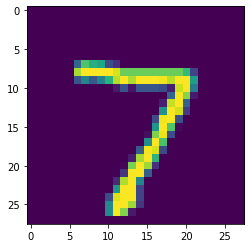

displaying a 7


In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)


    plt.imshow(X[0][0].numpy())
    plt.show()
    print(f'displaying a {y[0]}')
    break

# Define the batch normalization model

The baseline system should use the following: Glorot initialization, ReLU activations, mini-batch
stochastic gradient descent with momentum (β = 0.9), model selection and a cross-entropy loss
function. Use a learning rate scheduler to adjust the learning rate by 10% every 10 epochs, starting
with a learning rate of 0.05

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=8)
        self.conv2 = nn.Conv2d(12, 12, kernel_size=8)

        self.bn1 = nn.BatchNorm2d(12)
        self.bn2 = nn.BatchNorm2d(12)

        self.fc1 = nn.Linear(7*7*12, 30)
        self.fc2 = nn.Linear(30, 10)

        torch.nn.init.xavier_uniform(self.conv1.weight)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        torch.nn.init.xavier_uniform(self.fc2.weight)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = x.view(-1,7*7*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = BaselineCNN().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

Using cuda device


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


BaselineCNN(
  (conv1): Conv2d(1, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=588, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)


Training loop is based on https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [5]:
train_losses = []
test_losses = []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_losses.append(loss)

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    test_losses.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
    scheduler.step()
print("Done!")

Epoch 1
-------------------------------
loss: 2.604562  [    0/60000]
loss: 0.161837  [ 6400/60000]
loss: 0.171974  [12800/60000]
loss: 0.204889  [19200/60000]
loss: 0.059711  [25600/60000]
loss: 0.071688  [32000/60000]
loss: 0.085518  [38400/60000]
loss: 0.179079  [44800/60000]
loss: 0.255764  [51200/60000]
loss: 0.048788  [57600/60000]
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.001062 

Epoch 2
-------------------------------
loss: 0.029807  [    0/60000]
loss: 0.063681  [ 6400/60000]
loss: 0.090205  [12800/60000]
loss: 0.037176  [19200/60000]
loss: 0.008123  [25600/60000]
loss: 0.046485  [32000/60000]
loss: 0.072721  [38400/60000]
loss: 0.118842  [44800/60000]
loss: 0.123566  [51200/60000]
loss: 0.039919  [57600/60000]
Test Error: 
 Accuracy: 94.6%, Avg loss: 0.003067 

Epoch 3
-------------------------------
loss: 0.092960  [    0/60000]
loss: 0.086706  [ 6400/60000]
loss: 0.038609  [12800/60000]
loss: 0.063357  [19200/60000]
loss: 0.007697  [25600/60000]
loss: 0.097762  [32000/600

Generate learning curves for the validation and training set. Discuss whether this base-
line system overfits, underfits or reasonably fits the validation data. Test this baseline system with
the testing data and report the accuracy and show a confusion matrix

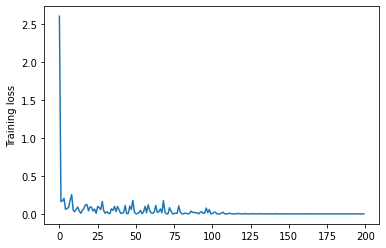

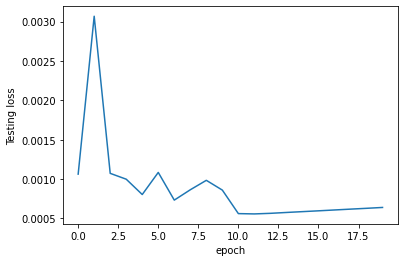

In [6]:
plt.plot(train_losses)
plt.ylabel('Training loss')
plt.show()

plt.plot(test_losses)
plt.ylabel('Testing loss')
plt.xlabel('epoch')
plt.show()

Like most of the other variations on the baseline, it quickly gets to a good accuracy after a couple epochs and then stays there. In this case, it reaches 98% accuracy after a single epoch.